In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score

#from plotnine import *
#from plotnine.data import *

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from plot_metric.functions import BinaryClassification # pip install plot-metric

import warnings
warnings.filterwarnings("ignore")

In [ ]:
model_df = pd.read_csv("hotels_dev.csv")

In [ ]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           44998 non-null  object 
 1   lead_time                       44998 non-null  float64
 2   stays_in_weekend_nights         44998 non-null  float64
 3   stays_in_week_nights            44998 non-null  float64
 4   adults                          44998 non-null  float64
 5   children                        44998 non-null  float64
 6   meal                            44998 non-null  object 
 7   market_segment                  44998 non-null  object 
 8   distribution_channel            44998 non-null  object 
 9   is_repeated_guest               44998 non-null  float64
 10  previous_cancellations          44998 non-null  float64
 11  previous_bookings_not_canceled  44998 non-null  float64
 12  reserved_room_type              

In [ ]:
model_df.isnull().sum()

hotel                             2
lead_time                         2
stays_in_weekend_nights           2
stays_in_week_nights              2
adults                            2
children                          2
meal                              2
market_segment                    2
distribution_channel              2
is_repeated_guest                 2
previous_cancellations            2
previous_bookings_not_canceled    2
reserved_room_type                2
assigned_room_type                2
booking_changes                   2
deposit_type                      2
days_in_waiting_list              2
customer_type                     2
average_daily_rate                2
required_car_parking_spaces       2
total_of_special_requests         2
arrival_date                      2
dtype: int64

In [ ]:
model_df = model_df.dropna()
model_df['children'].astype('double') # convert to double
model_df.drop('arrival_date', axis=1, inplace=True)

**Model 1 Building**

In [ ]:
model_1_features = ['market_segment', 'adults', 'customer_type', 'is_repeated_guest']

In [ ]:
X_model_1 = model_df[model_1_features]
Y_model_1 = model_df['children']

In [ ]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X_model_1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [ ]:
X_train_model_1, X_test_model_1, y_train_model_1, y_test_model_1 = train_test_split(X_scaled, Y_model_1, test_size=0.2, random_state=42)

In [ ]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train_model_1, y_train_model_1)

probs = model_1.predict_proba(X_test_model_1)[:,-1]
predictions = model_1.predict(X_test_model_1)

In [ ]:
y_proba_model_1 = model_1.predict_proba(X_test_model_1)[:, 1]
roc_auc_model_1 = roc_auc_score(y_test_model_1, y_proba_model_1)
print(f"Model 1 Test ROC-AUC: {roc_auc_model_1:.4f}")

Model 1 Test ROC-AUC: 0.6942


In [ ]:
fpr_model_1, tpr_model_1, threshold_model_1 = roc_curve(y_test_model_1, y_proba_model_1)

In [ ]:
confusion_matrix(y_test_model_1, predictions)

array([[8261,    9],
       [ 719,   11]])

In [ ]:
predictions_test = predictions
accuracy_test = accuracy_score(y_test_model_1, predictions_test)
predictions_train = model_1.predict(X_train_model_1)
accuracy_train = accuracy_score(y_train_model_1, predictions_train)
print("Train accuracy is = ", accuracy_train)
print("Test accuracy is = ", accuracy_test)

Train accuracy is =  0.919551086171454
Test accuracy is =  0.9191111111111111


**Model 2 Building**

In [ ]:
SEED = 365
TARGET = 'children'
FEATURES = model_df.columns.drop(TARGET)

NUMERICAL = model_df[FEATURES].select_dtypes('number').columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: lead_time, stays_in_weekend_nights, stays_in_week_nights, adults, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, average_daily_rate, total_of_special_requests
Categorical features: assigned_room_type, customer_type, deposit_type, distribution_channel, hotel, market_segment, meal, required_car_parking_spaces, reserved_room_type


In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

X = model_df.drop(columns=TARGET)
Y = model_df[TARGET]

num_imputer = SimpleImputer(strategy='mean')
num_imputed = num_imputer.fit_transform(X[NUMERICAL])

scaler = MinMaxScaler()
num_scaled = scaler.fit_transform(num_imputed)

cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
cat_imputed = cat_imputer.fit_transform(X[CATEGORICAL])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
cat_encoded = encoder.fit_transform(cat_imputed)

preprocessed = np.concatenate((num_scaled,cat_encoded), axis=1)

columns = np.append(NUMERICAL, encoder.get_feature_names_out(CATEGORICAL))
preprocessed = pd.DataFrame(preprocessed, columns=columns, index=X.index)

In [ ]:
preprocessed.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,average_daily_rate,...,meal_SC,meal_Undefined,required_car_parking_spaces_parking,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H
0,0.306065,0.052632,0.06,0.5,0.0,0.0,0.0,0.000000,0.0,0.168732,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.133992,0.105263,0.10,0.5,0.0,0.0,0.0,0.095238,0.0,0.027848,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.201693,0.105263,0.12,0.5,0.0,0.0,0.0,0.000000,0.0,0.169216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.094499,0.105263,0.04,0.5,0.0,0.0,0.0,0.000000,0.0,0.107421,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008463,0.105263,0.04,0.5,0.0,0.0,0.0,0.000000,0.0,0.360936,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44998 entries, 0 to 44997
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   lead_time                            44998 non-null  float64
 1   stays_in_weekend_nights              44998 non-null  float64
 2   stays_in_week_nights                 44998 non-null  float64
 3   adults                               44998 non-null  float64
 4   is_repeated_guest                    44998 non-null  float64
 5   previous_cancellations               44998 non-null  float64
 6   previous_bookings_not_canceled       44998 non-null  float64
 7   booking_changes                      44998 non-null  float64
 8   days_in_waiting_list                 44998 non-null  float64
 9   average_daily_rate                   44998 non-null  float64
 10  total_of_special_requests            44998 non-null  float64
 11  assigned_room_type_B             

In [ ]:
train_preprocessed, test_preprocessed, y_train, y_test = train_test_split(preprocessed, Y, test_size=0.2, random_state=SEED)

In [ ]:
model = LogisticRegression()
model.fit(train_preprocessed, y_train)

probs = model.predict_proba(test_preprocessed)[:,-1]
predictions = model.predict(test_preprocessed)

In [ ]:
confusion_matrix(y_test, predictions)

array([[8157,   99],
       [ 480,  264]])

In [ ]:
predictions_test = predictions
accuracy_test = accuracy_score(y_test, predictions_test)
predictions_train = model.predict(train_preprocessed)
accuracy_train = accuracy_score(y_train, predictions_train)
print("Train accuracy is = ", accuracy_train)
print("Test accuracy is = ", accuracy_test)

Train accuracy is =  0.9363297960997833
Test accuracy is =  0.9356666666666666


**Run Model 2 on the Test dataset because it has the higher accuracy score.**

In [ ]:
test_data = pd.read_csv("/content/hotels_test.csv")

In [ ]:
test_data = test_data.dropna()
hotel_test['children'] = hotel_test['children'].astype('double')

In [ ]:
print(test_data.head())
print(test_data.describe())
print(test_data.info())

          hotel  lead_time  stays_in_weekend_nights  stays_in_week_nights  \
0  Resort_Hotel         47                        0                     2   
1  Resort_Hotel         46                        0                     2   
2    City_Hotel         22                        1                     2   
3  Resort_Hotel        209                        2                     5   
4    City_Hotel          1                        1                     0   

   adults  children meal market_segment distribution_channel  \
0       2         1   BB         Direct               Direct   
1       2         0   BB  Offline_TA/TO                TA/TO   
2       2         0   BB      Online_TA                TA/TO   
3       2         0   BB  Offline_TA/TO                TA/TO   
4       2         0   SC      Online_TA                TA/TO   

   is_repeated_guest  ...  reserved_room_type  assigned_room_type  \
0                  0  ...                   C                   C   
1             

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X_test_data = test_data.drop('children', axis=1)
Y_test_data = test_data['children'].astype(int)

categorical_cols = X_test_data.select_dtypes(include=['object', 'bool']).columns
numerical_cols = X_test_data.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



In [ ]:
from sklearn.linear_model import LogisticRegression

X_preprocessed = preprocessor.fit_transform(X_test_data)

model = LogisticRegression(max_iter=1000)
model.fit(X_preprocessed, Y_test_data)


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba_test = model.predict_proba(X_preprocessed)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test_data, y_proba_test)
roc_auc = roc_auc_score(Y_test_data, y_proba_test)

print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresholds)
print("ROC AUC:", roc_auc)


FPR: [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.17533174e-04
 2.17533174e-04 4.35066348e-04 4.35066348e-04 6.52599521e-04
 6.52599521e-04 8.70132695e-04 8.70132695e-04 1.08766587e-03
 1.08766587e-03 1.30519904e-03 1.30519904e-03 1.52273222e-03
 1.52273222e-03 1.74026539e-03 1.74026539e-03 1.95779856e-03
 1.95779856e-03 2.17533174e-03 2.17533174e-03 2.39286491e-03
 2.39286491e-03 2.61039809e-03 2.61039809e-03 2.82793126e-03
 2.82793126e-03 3.26299761e-03 3.26299761e-03 3.48053078e-03
 3.48053078e-03 3.69806395e-03 3.69806395e-03 4.13313030e-03
 4.13313030e-03 4.35066348e-03 4.35066348e-03 4.56819665e-03
 4.56819665e-03 5.00326300e-03 5.00326300e-03 5.22079617e-03
 5.22079617e-03 5.43832935e-03 5.43832935e-03 5.65586252e-03
 5.65586252e-03 5.87339569e-03 5.87339569e-03 6.09092887e-03
 6.09092887e-03 6.74352839e-03 6.74352839e-03 6.96106156e-03
 6.96106156e-03 7.39612791e-03 7.39612791e-03 7.61366108e-03
 7.61366108e-03 7.83119426e-03 7.83119426e-03 8.04872743e-03
 8.04872743e-03 8.4

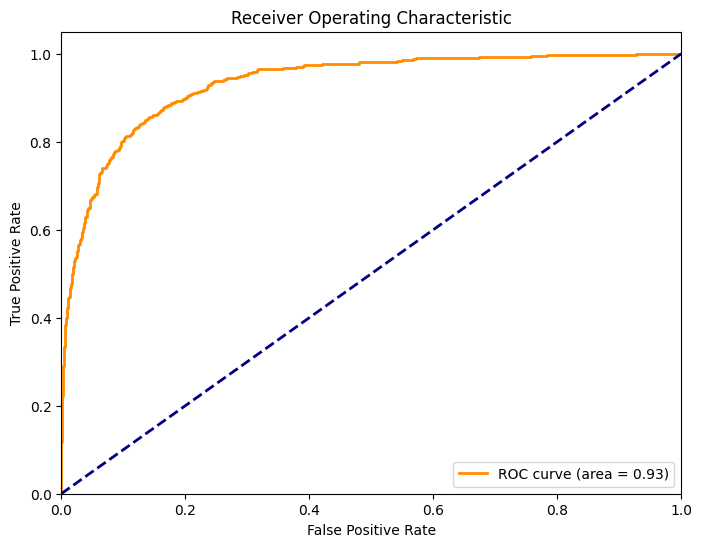

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
